In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Read in and Clean Data

In [2]:
df = pd.read_parquet('../../data/bike_trips_cleaned.parquet')

In [3]:
df.head(10)

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,end_station_name,start_station_name,duration,start_lat,start_lon,end_lat,end_lon,distance,speed,average_time,date_time,max_temp,min_temp,precip
index,,,,,,,,,,,,,,,,,,,,
0,2016-01-01 00:04:00,2016-01-01 00:14:00,3046,3041,3564,Indego30,"Girard Station, MFL",2nd & Market,0 days 00:10:00,39.949895,-75.143749,39.969241,-75.136180,1.005648,6.033888,2016-01-01 00:09:00,2016-01-01 00:00:00,6.7,6.7,0.0
1,2016-01-01 00:07:00,2016-01-01 00:29:00,3028,3019,2629,Indego30,6th & Race,4th & Bainbridge,0 days 00:22:00,39.940735,-75.149370,39.954694,-75.149496,0.397798,1.084905,2016-01-01 00:18:00,2016-01-01 00:00:00,6.7,6.7,0.0
2,2016-01-01 00:14:00,2016-01-01 00:27:00,3007,3066,3430,Indego30,19th & Lombard,"11th & Pine, Kahn Park",0 days 00:13:00,39.945123,-75.159952,39.945664,-75.173272,1.480278,6.832050,2016-01-01 00:20:30,2016-01-01 00:00:00,6.7,6.7,0.0
3,2016-01-01 00:20:00,2016-01-01 00:30:00,3045,3028,3715,Indego30,4th & Bainbridge,13th & Locust,0 days 00:10:00,39.947947,-75.162361,39.940735,-75.149370,1.458133,8.748797,2016-01-01 00:25:00,2016-01-01 00:00:00,6.7,6.7,0.0
4,2016-01-01 00:20:00,2016-01-01 00:42:00,3005,3064,3351,Walk-up,"18th & Washington, Chew Playground","Welcome Park, NPS",0 days 00:22:00,39.947383,-75.144145,39.938280,-75.173873,3.313616,9.037136,2016-01-01 00:31:00,2016-01-01 01:00:00,7.2,7.2,0.0
5,2016-01-01 00:21:00,2016-01-01 00:42:00,3005,3064,3355,Walk-up,"18th & Washington, Chew Playground","Welcome Park, NPS",0 days 00:21:00,39.947383,-75.144145,39.938280,-75.173873,3.313616,9.467475,2016-01-01 00:31:30,2016-01-01 01:00:00,7.2,7.2,0.0
6,2016-01-01 00:26:00,2016-01-01 00:40:00,3005,3013,2636,Walk-up,6th & Fairmount,"Welcome Park, NPS",0 days 00:14:00,39.947383,-75.144145,39.963535,-75.147818,0.615070,2.636013,2016-01-01 00:33:00,2016-01-01 01:00:00,7.2,7.2,0.0
7,2016-01-01 00:27:00,2016-01-01 00:49:00,3046,3061,3344,Walk-up,23rd & Market,2nd & Market,0 days 00:22:00,39.949895,-75.143749,39.954151,-75.177827,3.788847,10.333219,2016-01-01 00:38:00,2016-01-01 01:00:00,7.2,7.2,0.0
8,2016-01-01 00:26:00,2016-01-01 00:51:00,3046,3061,3720,Walk-up,23rd & Market,2nd & Market,0 days 00:25:00,39.949895,-75.143749,39.954151,-75.177827,3.788847,9.093232,2016-01-01 00:38:30,2016-01-01 01:00:00,7.2,7.2,0.0


In [4]:
df['temp'] = (df['min_temp'] + df['max_temp']) / 2
df['hour']  = df['average_time'].dt.hour
df['duration'] = df['duration'] / pd.Timedelta(minutes=1)
df['is_weekday'] = df['date_time'].dt.dayofweek < 6

df['date_offset'] = (df.date_time.dt.month*100 + df.date_time.dt.day - 320)%1300

df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300],
                      labels=['spring', 'summer', 'autumn', 'winter'])

df["user_type"] = df["user_type"].astype('category')

#Remove not needed Cols
df = df.drop(columns=['start_station_id', 'end_station_id', 'start_time', 'end_time', 'bike_id', 'end_station_name', 'start_station_name', 'start_lat', 'start_lon', 'end_lon', 'end_lat', 'date_time', 'min_temp', 'max_temp', 'average_time', 'date_offset'])


df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 647057 entries, 0 to 647056
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   user_type   647057 non-null  category
 1   duration    647057 non-null  float64 
 2   distance    647057 non-null  float64 
 3   speed       647057 non-null  float64 
 4   precip      647057 non-null  float64 
 5   temp        647057 non-null  float64 
 6   hour        647057 non-null  int64   
 7   is_weekday  647057 non-null  bool    
 8   season      646604 non-null  category
dtypes: bool(1), category(2), float64(5), int64(1)
memory usage: 36.4 MB


In [5]:
df.head(10)

,user_type,duration,distance,speed,precip,temp,hour,is_weekday,season
index,,,,,,,,,
0,Indego30,10.0,1.005648,6.033888,0.0,6.7,0,True,winter
1,Indego30,22.0,0.397798,1.084905,0.0,6.7,0,True,winter
2,Indego30,13.0,1.480278,6.832050,0.0,6.7,0,True,winter
3,Indego30,10.0,1.458133,8.748797,0.0,6.7,0,True,winter
4,Walk-up,22.0,3.313616,9.037136,0.0,7.2,0,True,winter
5,Walk-up,21.0,3.313616,9.467475,0.0,7.2,0,True,winter
6,Walk-up,14.0,0.615070,2.636013,0.0,7.2,0,True,winter
7,Walk-up,22.0,3.788847,10.333219,0.0,7.2,0,True,winter
8,Walk-up,25.0,3.788847,9.093232,0.0,7.2,0,True,winter


# Visualize Cleaned Data
To see if good clusterings appear and what we can look for, we vis the data in a pairplot

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


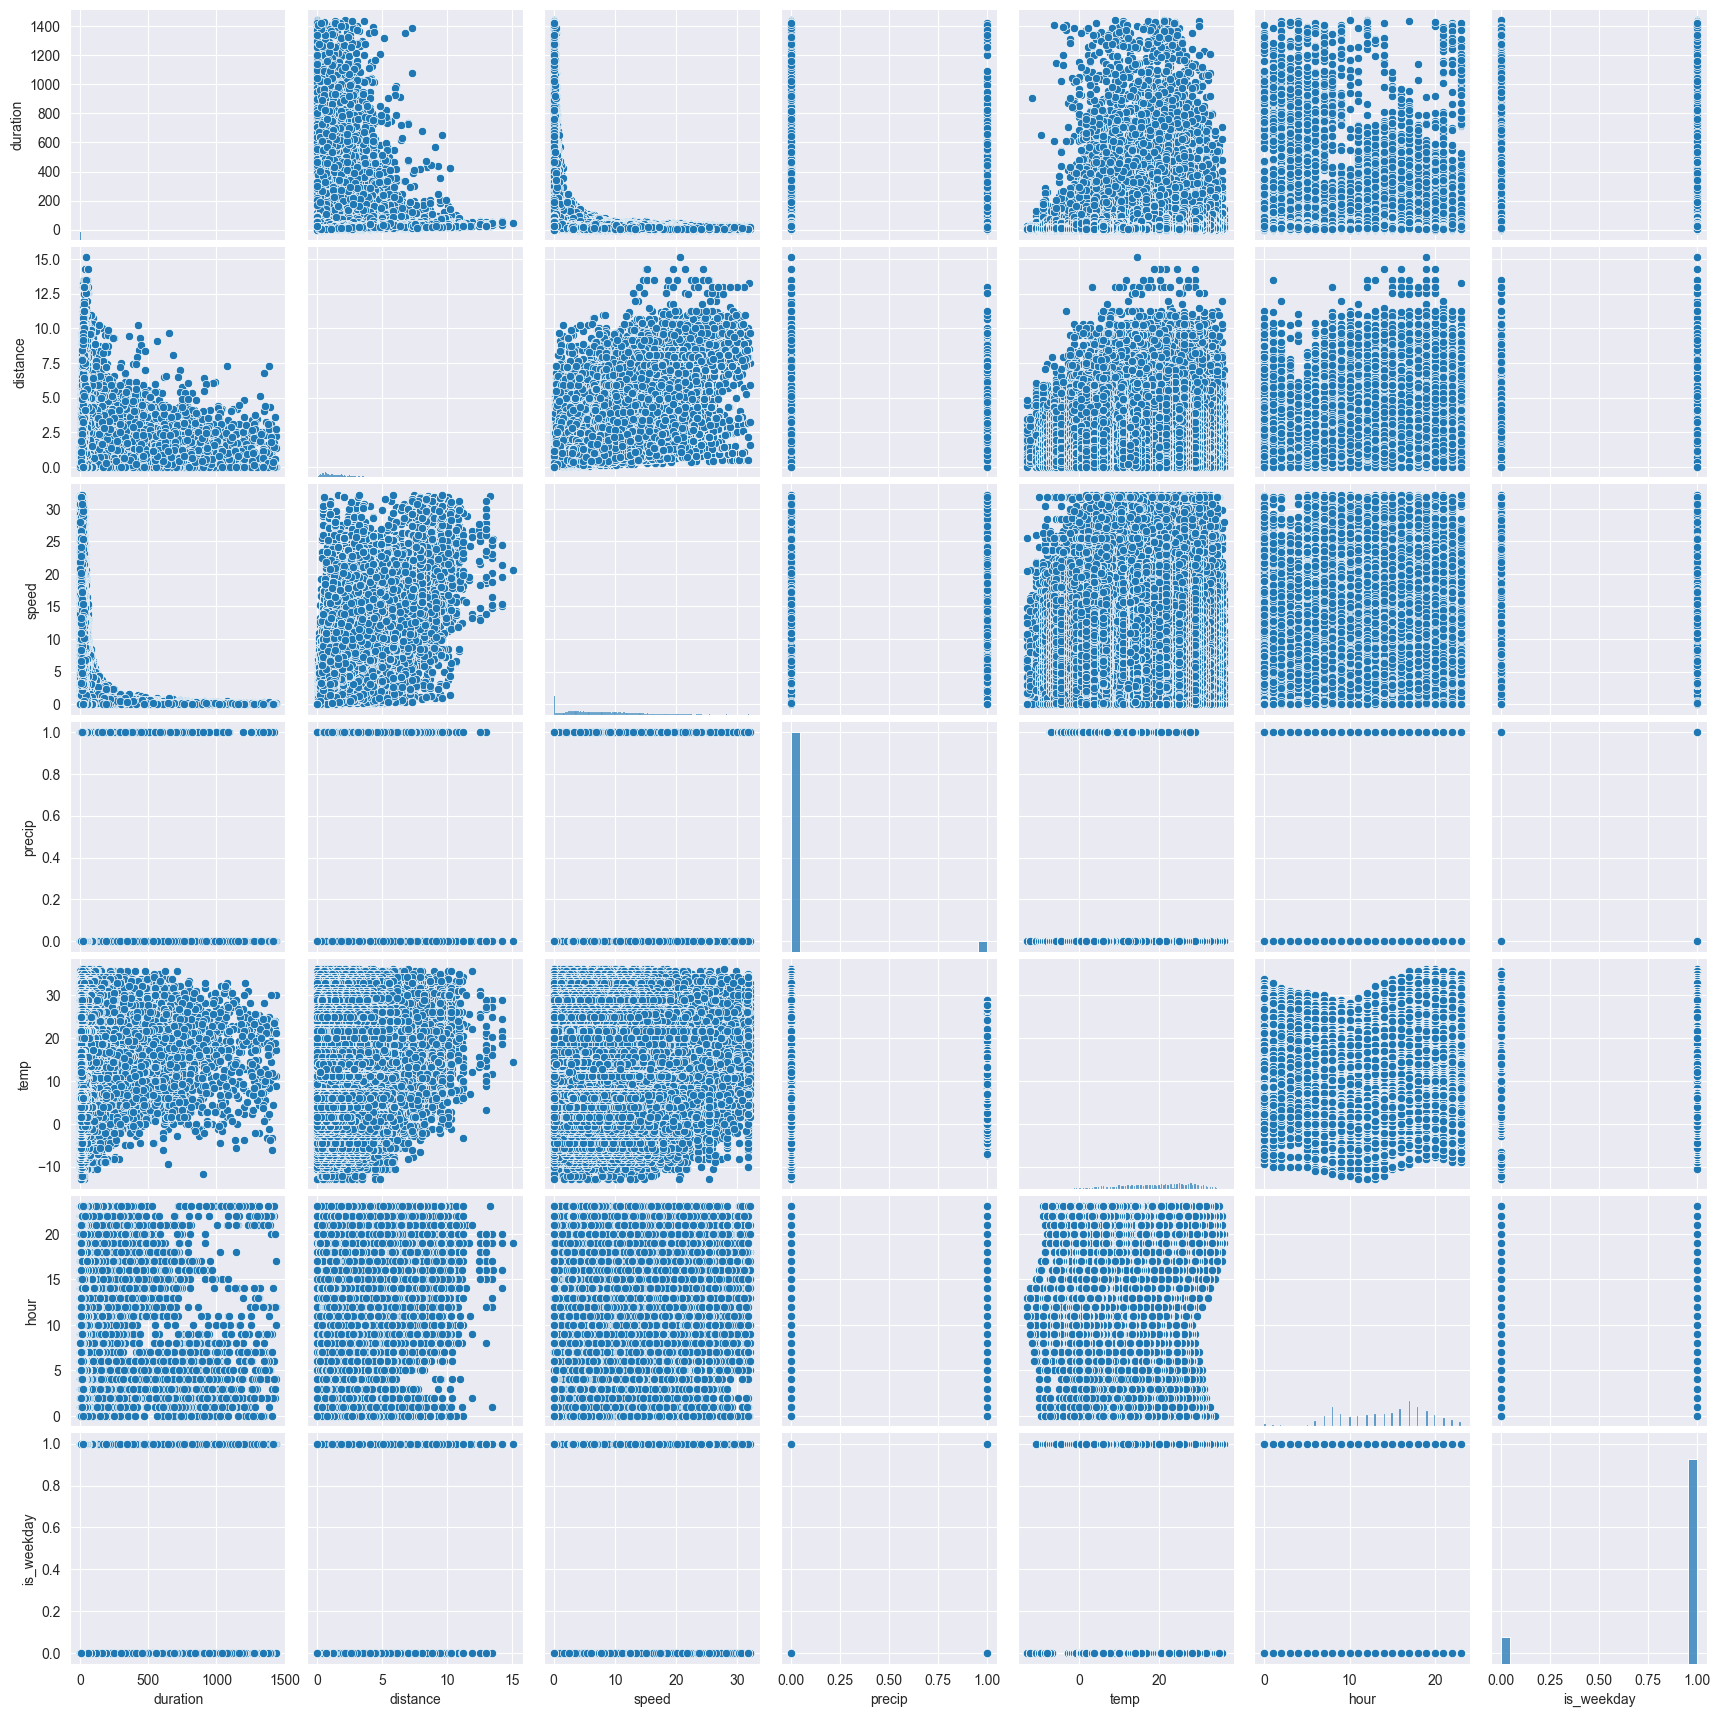

In [6]:
sns.pairplot(data=df)

After looking at the pairplot, it's visible for example, that most of the trips with longer distance occur when it is warmer. Furthermore, the speediest trips, were over long distance. You can also see, that the speed metric is a bit flawed, because when a user has a bike for a whole day, the distance between start and stop station are very low compared to the length of the rental.

# Scale the data
Scale, because the clustering algorithm works better with scaled data, as all the datapoints are in the same scale then

In [7]:
scaler = MinMaxScaler()

df = df.dropna()

df['user_type'].replace(['Indego30', 'Walk-up', 'IndegoFlex'], [1, 2, 3], inplace=True)
df['season'].replace(['spring', 'summer', 'autumn', 'winter'], [1,2,3,4], inplace=True)

df_scaled = scaler.fit_transform(df.to_numpy())

df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

C:\Users\jerem\AppData\Local\Temp\ipykernel_4568\879177870.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user_type'].replace(['Indego30', 'Walk-up', 'IndegoFlex'], [1, 2, 3], inplace=True)
C:\Users\jerem\AppData\Local\Temp\ipykernel_4568\879177870.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['season'].replace(['spring', 'summer', 'autumn', 'winter'], [1,2,3,4], inplace=True)


# PCA dim Reduction
Because we have 10 Dimensions we can look, if we are able to approximate with explained variance above 85% with a lower dimensionality. Then we can subdivide into less components

In [8]:
pca = PCA(n_components=5)
pca.fit_transform(df_scaled)
print(sum(pca.explained_variance_ratio_))

0.8664036384628567


Because the explained variance is over 85% we can use the fitted df

In [9]:
df_scaled = pca.fit_transform(df_scaled)

In [10]:
#ref: https://realpython.com/k-means-clustering-python/

kmeans_kwargs = {
    "n_init": "auto",
    "random_state": 11,
}

sse = []
for k in range(1,11): #Maximum Number of Clusters
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df_scaled)
    sse.append(kmeans.inertia_)

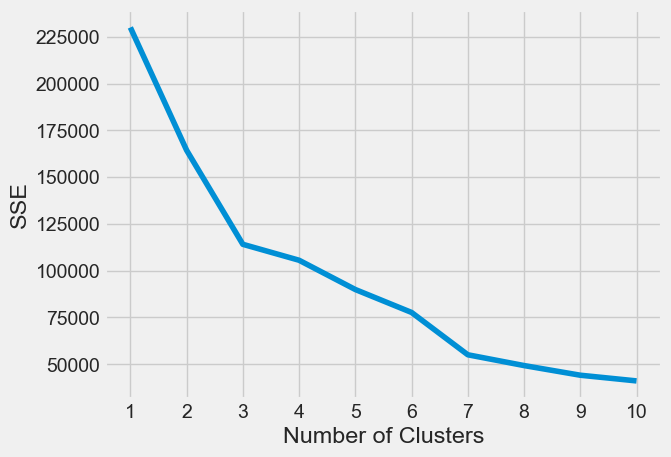

In [11]:
# plot losses
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

From the Graph it seems like 4 is the ideal amount of clusters, since it shows a clear edge, altough of course the loss gradually decreases, but this is usual, due to the model being able to fit the data better

In [12]:
f_means = KMeans(n_clusters=4, random_state=111, n_init='auto')
f_means.fit(df_scaled)
f_means.predict(df_scaled)

df['cluster'] = f_means.labels_
df['is_weekday'] = df['is_weekday'].astype('float64')

C:\Users\jerem\AppData\Local\Temp\ipykernel_4568\1138296365.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = f_means.labels_
C:\Users\jerem\AppData\Local\Temp\ipykernel_4568\1138296365.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_weekday'] = df['is_weekday'].astype('float64')


In [13]:
cluster_size = df.groupby('cluster').size()

cluster_size

cluster
0     30891
1    210499
2    334192
3     71022
dtype: int64

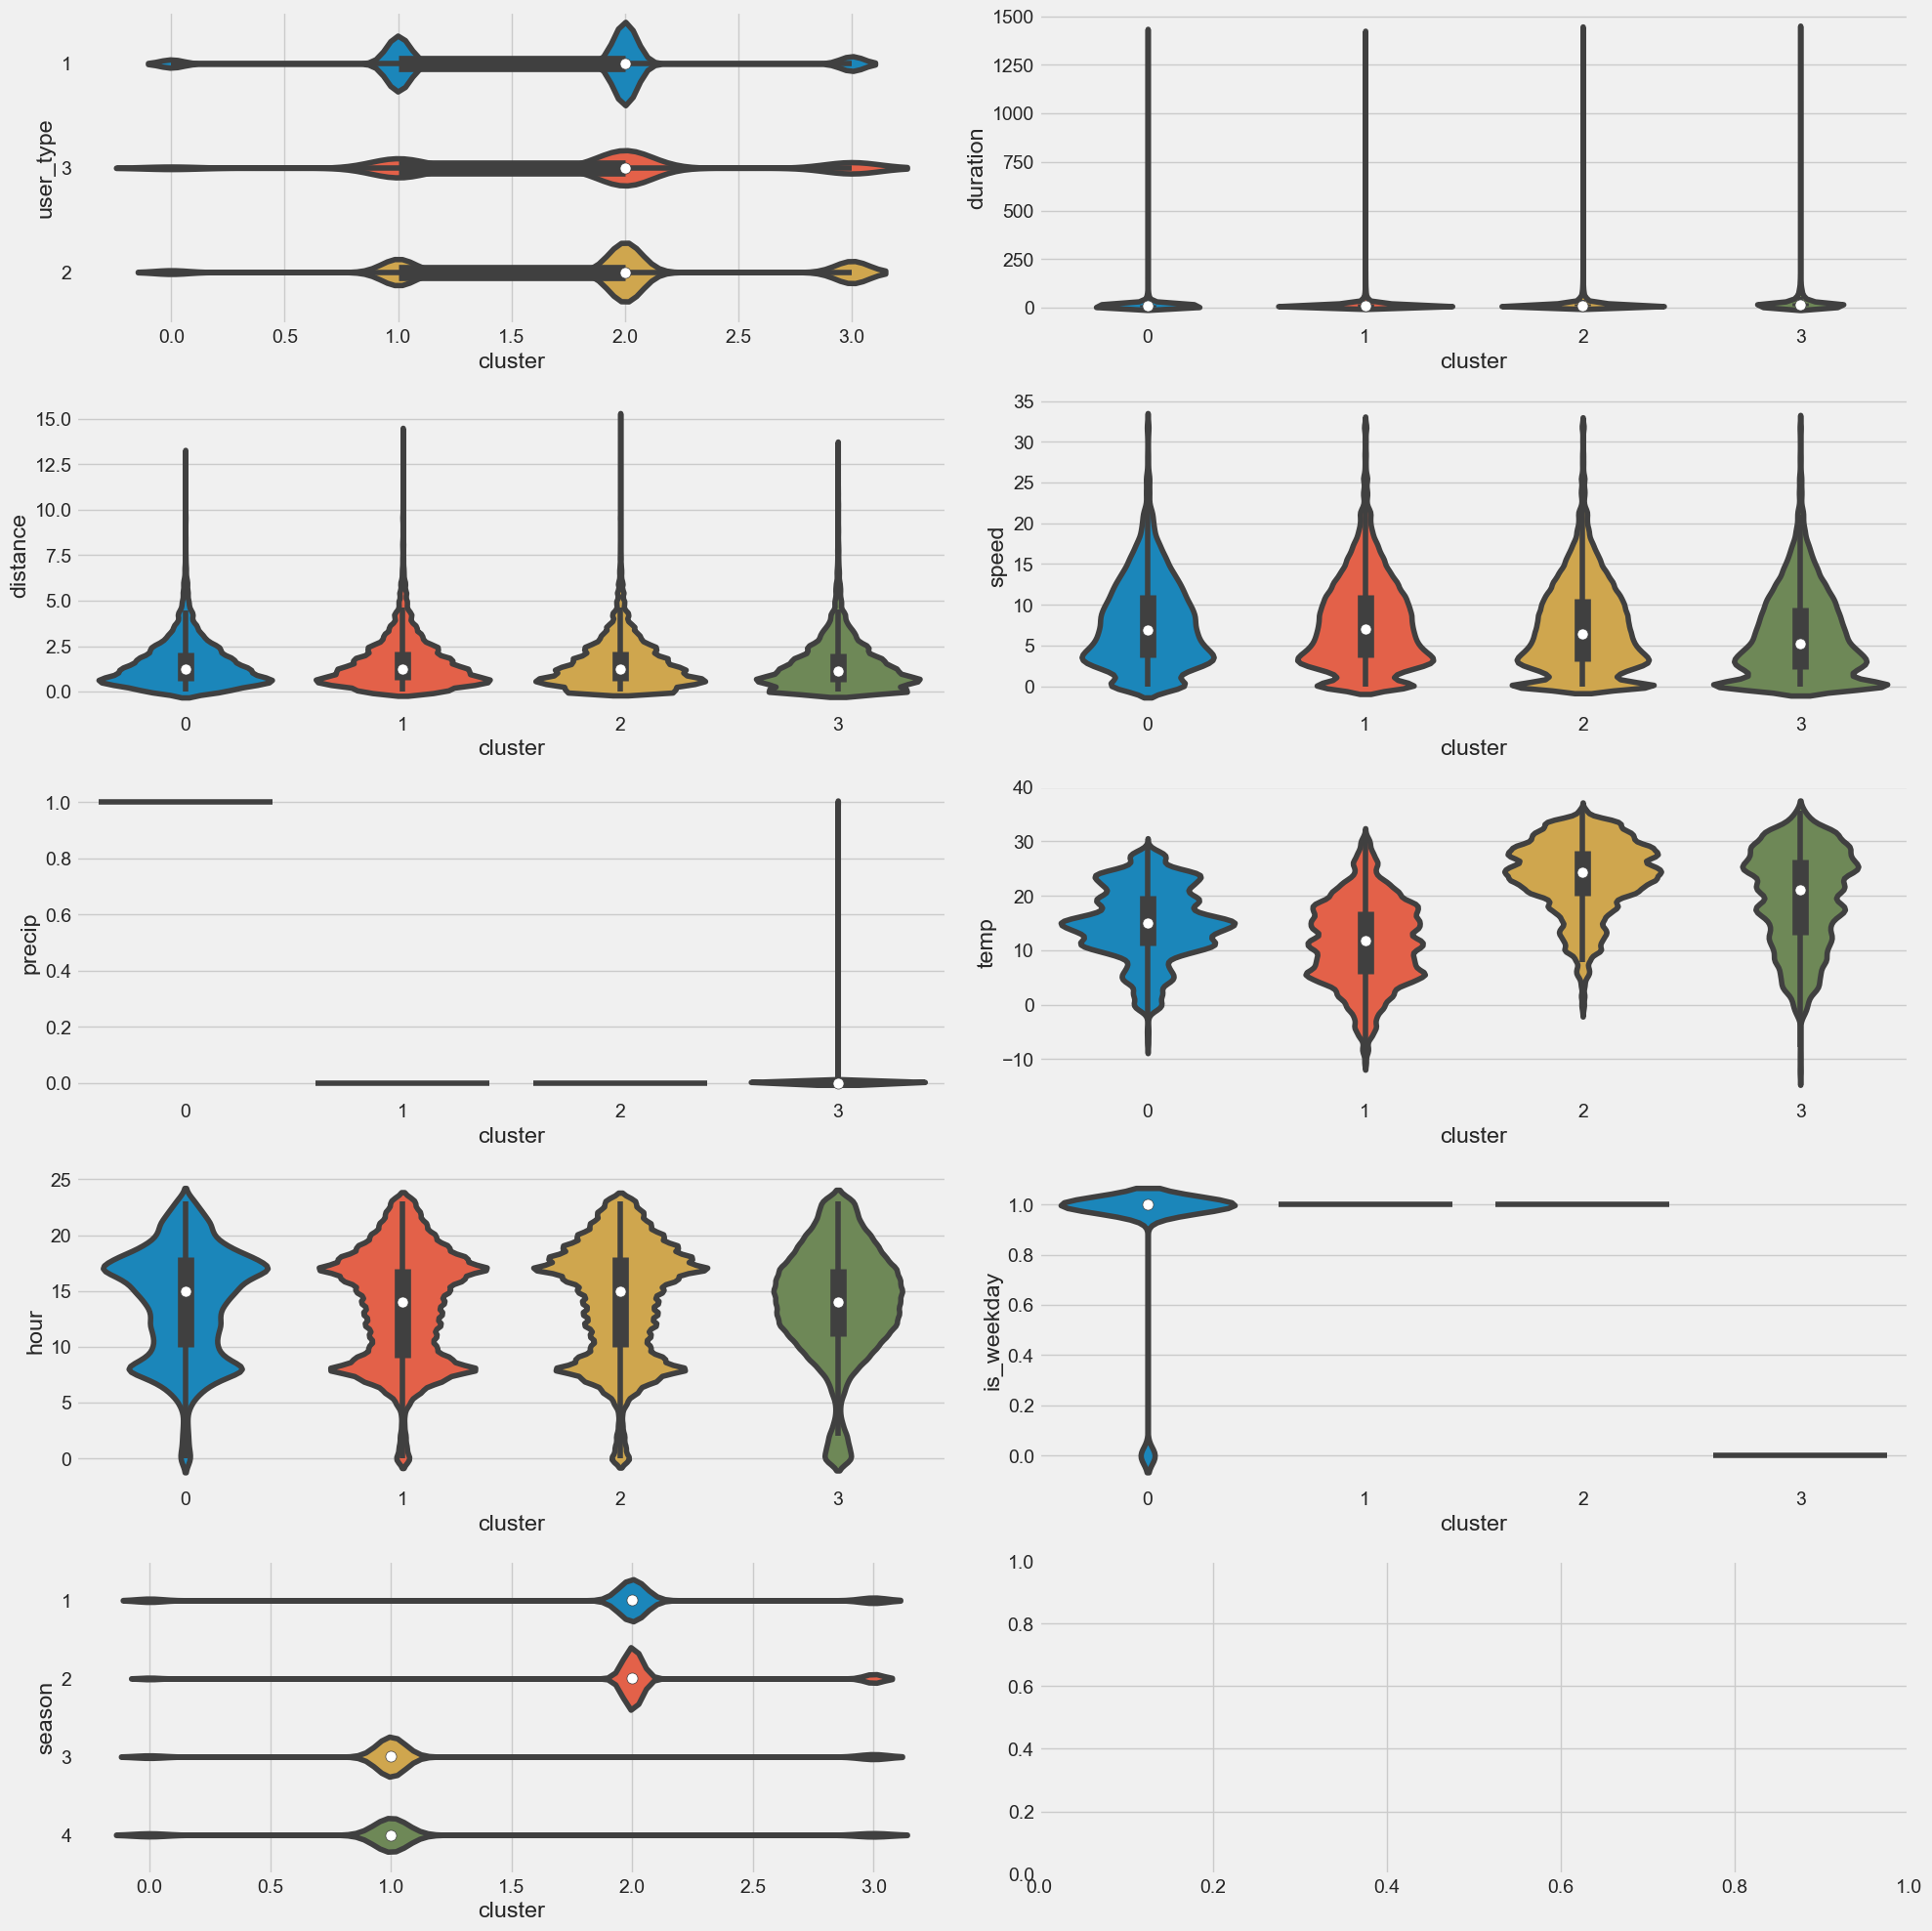

In [14]:
#ref: https://chartio.com/learn/charts/violin-plot-complete-guide/
#ref: https://towardsdatascience.com/visualizing-clusters-with-pythons-matplolib-35ae03d87489

fig, axs = plt.subplots((len(df.columns) - 1) // 2, 2)
fig.set_size_inches(20, 20)
for i, col in enumerate(df.columns):
    if col != "cluster":
        sns.violinplot(
            x=df["cluster"],
            y=df[col],
            ax=axs[i//2][i%2],
            data=df,
        )
plt.tight_layout()

# Analyzing and labelling clusters

When Analyzing the Clusters you can make out the following similarities:

Cluster 3: Sunny/Warm Weekend Trips for Leisure, many day trips
Cluster 2: Spring and Summer Trips with no Precip, Mostly for Business
Cluster 1: Auutumn and Winter Trips with no Precip, mostly for Business
Cluster: 0: Rainy Trips, mostly Business

When thinking about it, the categorization makes a lot of sense:

With Cluster 0 are mostly business users, that have a subscription and need the service to ride, so they'll also ride iin the rain and at most temperatures.
Cluster 1 also consists mostly of people who have a subscription, but that seem to be using it more flexibly, meaning not riding in the rain, and also in autumn and winter, where it's not so nice to ride a bike.
Cluster 2 also consists only of weekday trips but in higher temperature and mostly auutmn and Summer trips, what you can also see when looking at the usage hours.
Cluster 3 consists only of weekend trips that walk up so have no subscription and use it for leisure because they want to ride a bike.

In conclusion you could say, that clustering does make a lot of sense in this context to differentiate different trips that have a different meaning